In [1]:
# --- 1. 导入必要的库并设置项目路径 ---
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from tqdm import tqdm
from omegaconf import OmegaConf
import torch_geometric.data
import umap
from torch_geometric.nn import global_mean_pool

# 假设本 Notebook 位于项目的 'test/' 目录下
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
print(f"项目根目录已添加到系统路径: {PROJECT_ROOT}")

from src.models.combined_model import CombinedModel
from src.utils import set_seed, get_device, plot_umap_comparison
from src.data_loader import load_gene_graph_data, create_cells_by_day_mapping
from src.losses import CombinedLoss # Import CombinedLoss for metric calculation
from src.evaluate import _get_point_estimate_from_params, _reshape_params_for_loss_or_eval

项目根目录已添加到系统路径: /root/autodl-tmp/scGODE3


In [2]:
# ## 2. 配置
# --- 用户可配置参数 ---

# 指向您的主配置文件
CONFIG_PATH = os.path.join(PROJECT_ROOT, "configs/main_config.yaml")

# 指向您已经训练好的、想要评估的【联合模型】检查点
CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "results/experiment_stable_start/checkpoints/joint_train_best.pt")

# 要评估的时间点将从数据中自动获取

# --- 可视化参数 ---
NUM_SAMPLES_PER_DAY = 100 # 为每个时间点采样的细胞数量
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
UMAP_METRIC = 'euclidean'
UMAP_RANDOM_STATE = 42

In [3]:
# ## 3. 加载配置、数据和模型
if not os.path.exists(CONFIG_PATH):
    raise FileNotFoundError(f"配置文件未找到: {CONFIG_PATH}")
config = OmegaConf.load(CONFIG_PATH)

set_seed(config.seed)
device = get_device(config.training_params.device)
print(f"正在使用设备: {device}")

# --- 加载数据 ---
print("正在加载数据...")
actual_data_dir = config.data_params.data_dir
if not os.path.isabs(actual_data_dir):
    actual_data_dir = os.path.join(PROJECT_ROOT, actual_data_dir)
if not os.path.exists(actual_data_dir):
    raise FileNotFoundError(f"数据目录未找到: {actual_data_dir}")
X_all_np, shared_edge_index, shared_edge_weight, gene_names, cell_names, meta_df = \
    load_gene_graph_data(actual_data_dir, config)
cells_by_day_indices = create_cells_by_day_mapping(meta_df, cell_names)
print("数据加载完成。")

# --- 加载模型和损失函数 ---
print(f"正在从检查点加载模型: {CHECKPOINT_PATH}")
if not os.path.exists(CHECKPOINT_PATH):
    raise FileNotFoundError(f"检查点文件未找到: {CHECKPOINT_PATH}")
model = CombinedModel(config)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

state_dict = checkpoint['model_state_dict']
if all(key.startswith('module.') for key in state_dict.keys()):
    print("检查点来自DDP模型，正在移除 'module.' 前缀。")
    state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()
print("模型加载完成。")

loss_fn = CombinedLoss(config.loss_weights, config=config, device=device)

# --- 获取模型和数据参数 ---
is_variational = bool(config.model_params.encoder.get("is_variational", False))
decoder_distribution = config.model_params.decoder.get("distribution", "gaussian")
num_dist_params = config.model_params.decoder.get("num_dist_params", 2)
num_genes = int(config.model_params.num_genes)

DAYS_TO_EVALUATE = sorted(cells_by_day_indices.keys())
print(f"将自动评估以下所有时间点: {DAYS_TO_EVALUATE}")

正在使用设备: cuda
正在加载数据...
数据加载完成。
正在从检查点加载模型: /root/autodl-tmp/scGODE3/results/experiment_stable_start/checkpoints/joint_train_best.pt
模型加载完成。
将自动评估以下所有时间点: [8.25, 8.5, 8.75, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0]


/tmp/ipykernel_39458/1491343068.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)


In [4]:
# ## 4. 生成重构数据并计算指标
# --- 初始化数据和指标收集容器 ---
all_expressions_list, all_latent_list = [], []
all_type_labels_list, all_day_labels_list = [], []
metrics_per_day = {}
days_for_metrics = []

with torch.no_grad():
    for day in tqdm(DAYS_TO_EVALUATE, desc="处理各个时间点"):
        if day not in cells_by_day_indices or len(cells_by_day_indices[day]) == 0:
            print(f"警告: 时间点 {day} 没有有效细胞，跳过。")
            continue
        
        day_indices = np.random.choice(cells_by_day_indices[day], min(NUM_SAMPLES_PER_DAY, len(cells_by_day_indices[day])), replace=False)
        real_expressions = X_all_np[day_indices]
        real_expressions_tensor = torch.from_numpy(real_expressions).float().to(device)
        
        day_data_list = [torch_geometric.data.Data(x=torch.tensor(expr, dtype=torch.float32).unsqueeze(-1), edge_index=shared_edge_index) for expr in real_expressions]
        day_batch_pyg = torch_geometric.data.Batch.from_data_list(day_data_list).to(device)
        
        # --- 1. 通过VGAE进行编码和解码 ---
        gae_outputs = model.graph_autoencoder(day_batch_pyg)
        
        # --- 2. 收集用于计算指标的张量 ---
        mu_nodes = gae_outputs.get("mu_nodes")
        log_var_nodes = gae_outputs.get("log_var_nodes")
        reconstructed_params = gae_outputs.get("reconstructed_params")
        reshaped_params = _reshape_params_for_loss_or_eval(reconstructed_params, real_expressions_tensor.shape, num_dist_params)
        recon_expressions_est = _get_point_estimate_from_params(reshaped_params, decoder_distribution, device)
        
        # --- 3. 计算定量指标 ---
        l_recon = loss_fn.recon_loss_fn(reshaped_params, real_expressions_tensor)
        l_kl = loss_fn.kl_loss_fn(mu_nodes, log_var_nodes) if is_variational else torch.tensor(0.0)
        l_ot_expr = loss_fn.ot_loss_expression_fn(recon_expressions_est, real_expressions_tensor) if loss_fn.ot_loss_expression_fn else torch.tensor(0.0)
        
        days_for_metrics.append(day)
        metrics_per_day.setdefault('L_recon', []).append(l_recon.item())
        metrics_per_day.setdefault('L_KL', []).append(l_kl.item())
        metrics_per_day.setdefault('L_OT_expression', []).append(l_ot_expr.item())
        
        # --- 4. 收集用于可视化的数据 ---
        # 表达空间
        all_expressions_list.append(real_expressions)
        all_expressions_list.append(recon_expressions_est.detach().cpu().numpy())
        
        # 潜空间
        real_latent_repr = mu_nodes if is_variational and mu_nodes is not None else gae_outputs.get("sampled_z_nodes")
        if real_latent_repr is not None and real_latent_repr.numel() > 0:
            all_latent_list.append(global_mean_pool(real_latent_repr, gae_outputs.get("z_batch")).detach().cpu().numpy())
        
        recon_data_list = [torch_geometric.data.Data(x=torch.tensor(expr, dtype=torch.float32).unsqueeze(-1), edge_index=shared_edge_index) for expr in recon_expressions_est.detach().cpu().numpy()]
        recon_batch_pyg = torch_geometric.data.Batch.from_data_list(recon_data_list).to(device)
        _, recon_mu_nodes, _, recon_batch, _ = model.graph_autoencoder.encode(recon_batch_pyg, return_pooling_details=False)
        recon_latent_repr = recon_mu_nodes if is_variational and recon_mu_nodes is not None else _
        if recon_latent_repr is not None and recon_latent_repr.numel() > 0:
            all_latent_list.append(global_mean_pool(recon_latent_repr, recon_batch).detach().cpu().numpy())
        
        # 标签
        all_day_labels_list.extend([day] * len(real_expressions))
        all_day_labels_list.extend([day] * len(recon_expressions_est))
        all_type_labels_list.extend(["Real"] * len(real_expressions))
        all_type_labels_list.extend(["Recon"] * len(recon_expressions_est))

# --- 合并所有数据 ---
if not all_expressions_list: raise ValueError("没有为UMAP收集到任何数据。")
combined_expressions_np = np.concatenate(all_expressions_list, axis=0)
combined_latent_np = np.concatenate(all_latent_list, axis=0)
day_labels_np = np.array(all_day_labels_list)
type_labels_np = np.array(all_type_labels_list)
print(f"为UMAP准备的总数据点数量: {combined_expressions_np.shape[0]}")

处理各个时间点: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]

为UMAP准备的总数据点数量: 4400


各项评估指标 (按时间点):


,L_recon,L_KL,L_OT_expression
8.25,0.951573,1.134605,843.569946
8.50,0.728648,0.610773,645.946045
8.75,0.915072,0.973673,811.211182
9.00,0.867973,0.869502,769.458374
9.50,1.303703,1.493906,1155.732910
10.00,1.518702,1.913488,1346.329346
10.50,1.468702,1.256091,1302.004517
11.00,1.629200,1.647641,1444.285645
11.50,1.451404,1.537131,1286.670044
12.00,1.604896,1.702048,1422.739868



各项指标的平均值:


,Average Value
L_recon,1.120197
L_KL,1.257419
L_OT_expression,993.054349



正在绘制评估指标随时间变化的趋势图...
指标趋势图已保存到: results/experiment_default/evaluation_output/metrics_vgae_reconstruction_vs_day.png


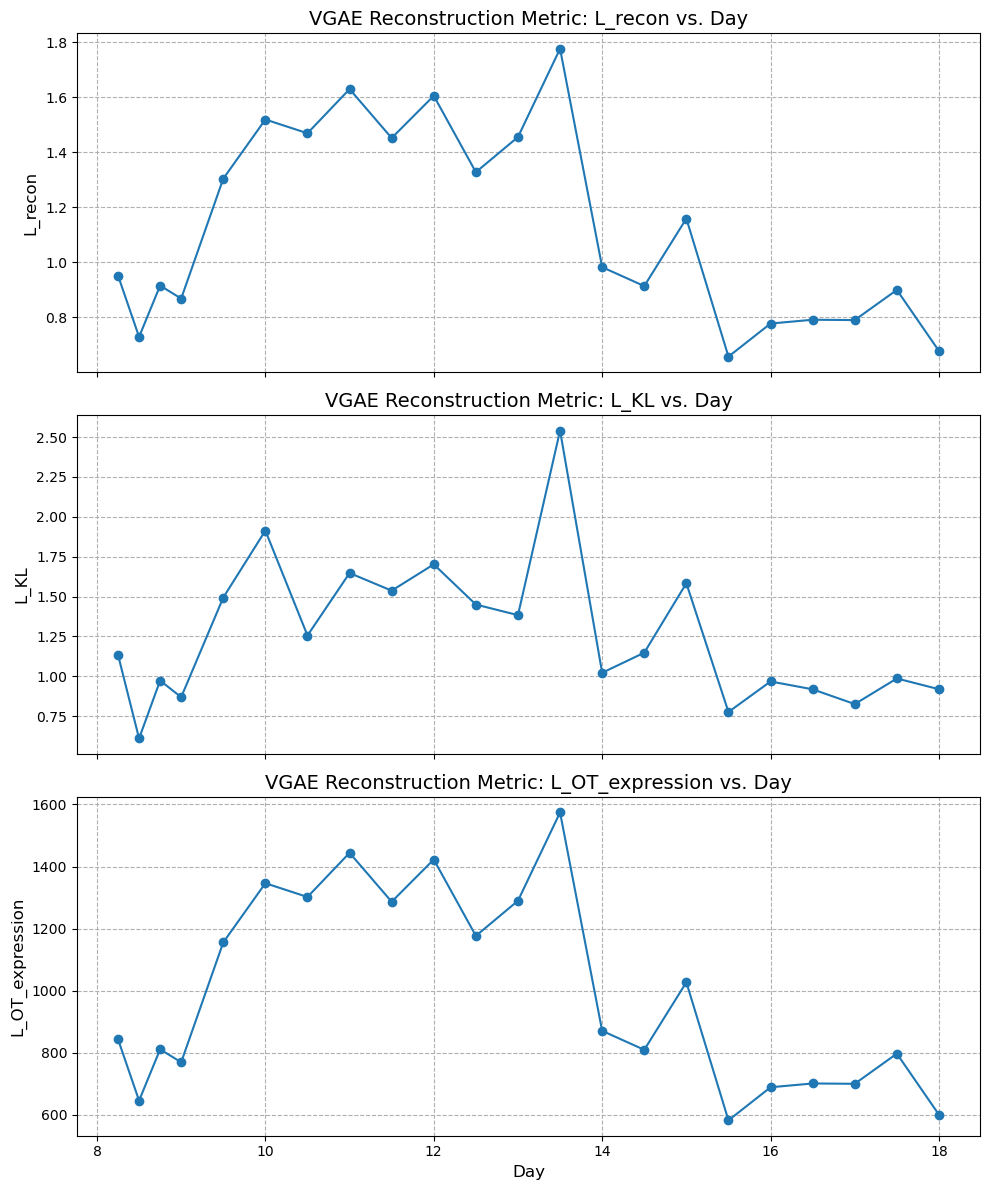

In [5]:
# ## 5. 定量评估结果
# 
# 下表展示了在每个时间点上，自编码器的重构性能指标。

# %%
# --- 创建并显示指标的DataFrame ---
metrics_df = pd.DataFrame(metrics_per_day, index=days_for_metrics)
print("各项评估指标 (按时间点):")
display(metrics_df)

print("\n各项指标的平均值:")
display(metrics_df.mean().to_frame('Average Value'))

# %% [markdown]
# ## 6. 绘制指标随时间变化的折线图

# %%
# --- 绘制折线图 ---
print("\n正在绘制评估指标随时间变化的趋势图...")
metric_keys_to_plot = [key for key, values in metrics_per_day.items() if values and not all(np.isnan(v) for v in values)]
if metric_keys_to_plot:
    fig, axes = plt.subplots(len(metric_keys_to_plot), 1, figsize=(10, 4 * len(metric_keys_to_plot)), sharex=True)
    if len(metric_keys_to_plot) == 1: axes = [axes]

    for ax, key in zip(axes, metric_keys_to_plot):
        ax.plot(days_for_metrics, metrics_per_day[key], marker='o', linestyle='-')
        ax.set_ylabel(key, fontsize=12)
        ax.set_title(f"VGAE Reconstruction Metric: {key} vs. Day", fontsize=14)
        ax.grid(True, linestyle='--')

    axes[-1].set_xlabel("Day", fontsize=12)
    plt.tight_layout()
    
    output_dir = config.evaluation_params.get("output_dir", "results/eval_output")
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"metrics_vgae_reconstruction_vs_day.png")
    plt.savefig(plot_filename, dpi=300)
    print(f"指标趋势图已保存到: {plot_filename}")

    plt.show()
else:
    print("没有有效的指标可以绘制。")


正在处理表达空间UMAP...


/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP图已保存到: results/experiment_default/evaluation_output/umap_vgae_reconstruction_expression_space.png


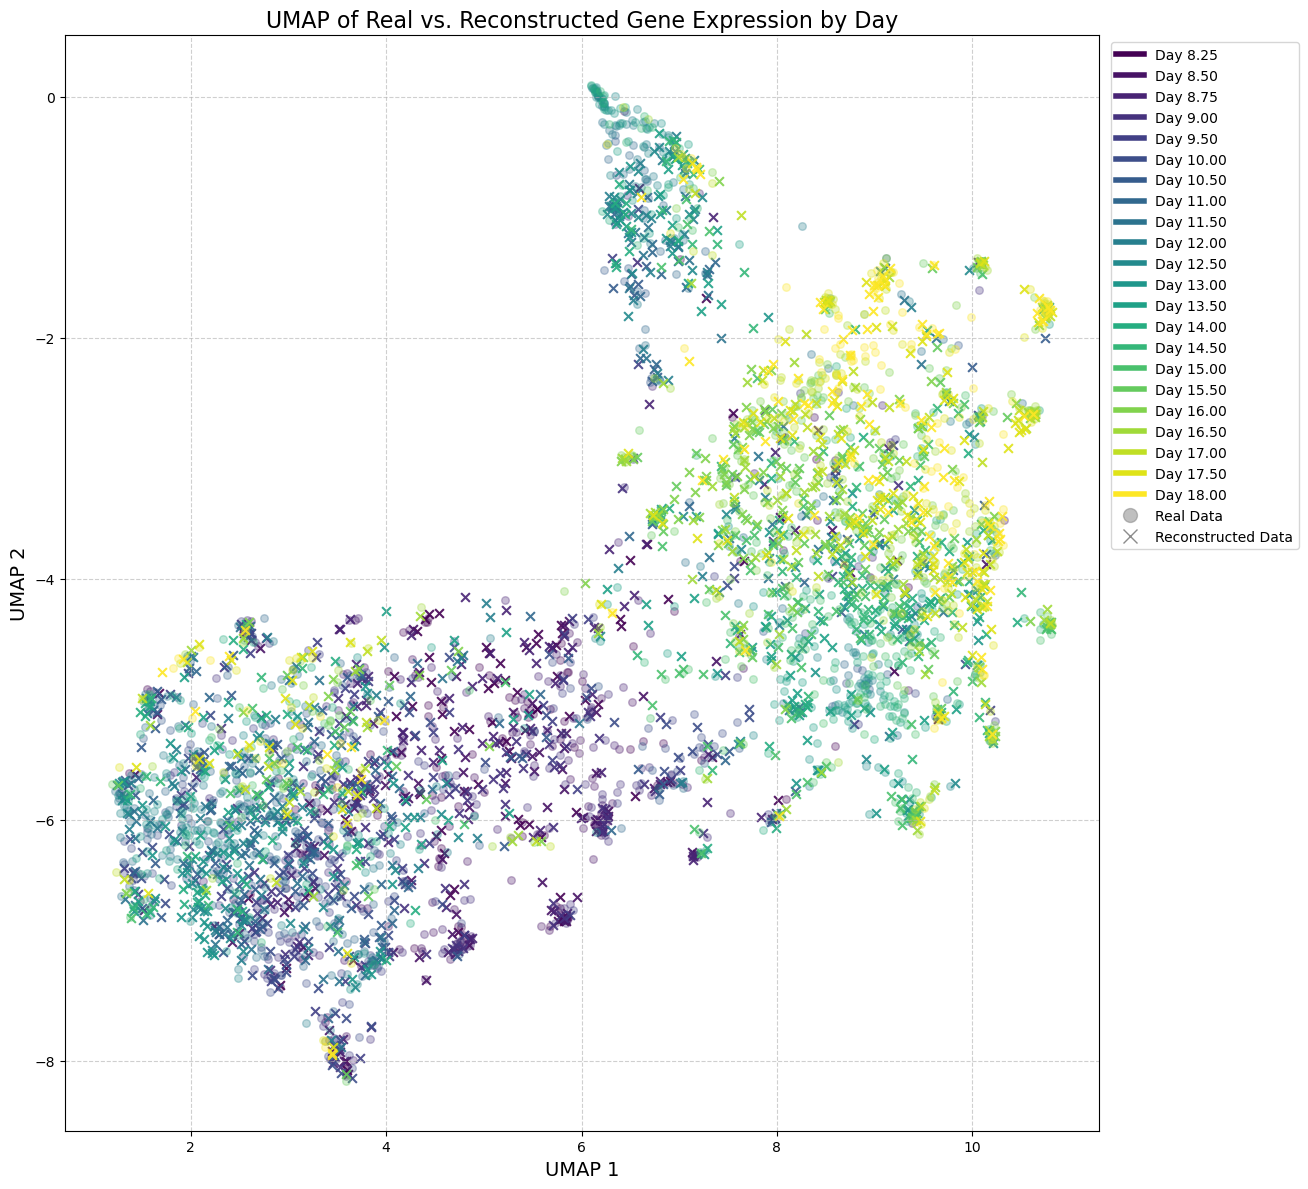


正在处理潜空间UMAP...


/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP图已保存到: results/experiment_default/evaluation_output/umap_vgae_reconstruction_latent_space.png


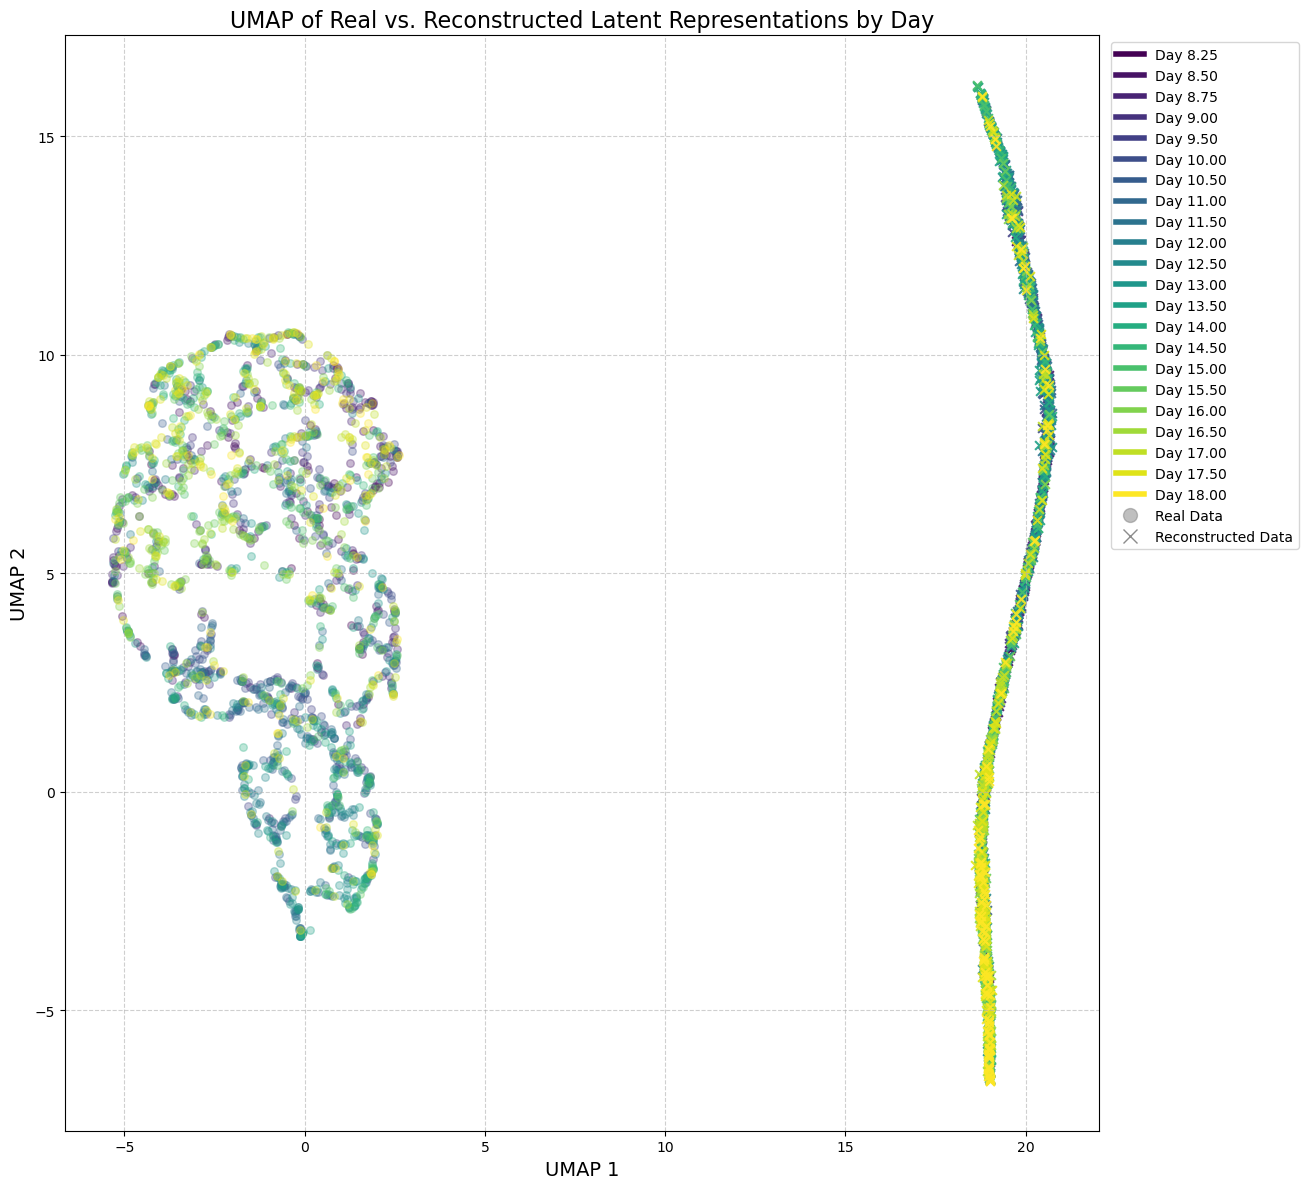

正在绘制仅包含真实数据的潜空间分布UMAP图...
真实潜空间UMAP图已保存到: results/experiment_default/evaluation_output/umap_real_latent_space_by_day_only.png


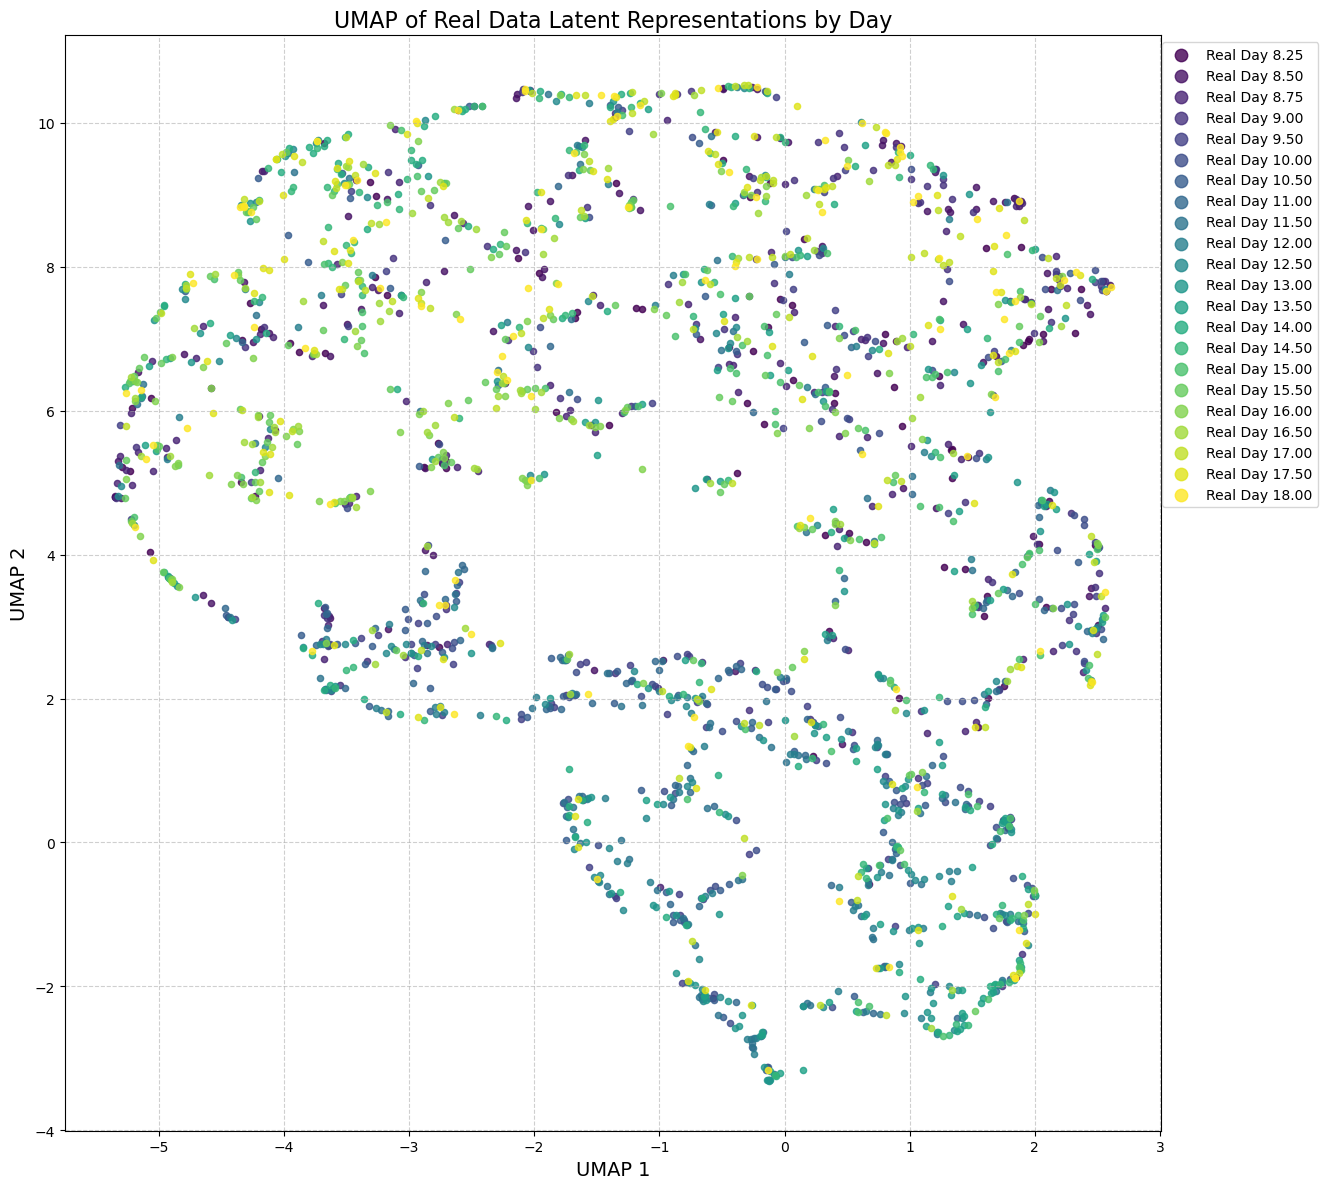

In [6]:
# ## 7. UMAP降维与定性可视化
def plot_space(embedding, day_labels, type_labels, title, output_filename, config):
    fig, ax = plt.subplots(figsize=(16, 12))
    unique_days = np.unique(day_labels)
    colors = plt.get_cmap('viridis', len(unique_days))
    day_to_color = {day: colors(i) for i, day in enumerate(unique_days)}

    for day in unique_days:
        real_idx = (day_labels == day) & (type_labels == "Real")
        recon_idx = (day_labels == day) & (type_labels == "Recon")
        color = day_to_color[day]
        
        ax.scatter(embedding[real_idx, 0], embedding[real_idx, 1], color=color, marker='o', s=30, alpha=0.3)
        ax.scatter(embedding[recon_idx, 0], embedding[recon_idx, 1], color=color, marker='x', s=40, alpha=0.9)

    day_legend_elements = [Line2D([0], [0], color=day_to_color[day], lw=4, label=f'Day {day:.2f}') for day in unique_days]
    marker_legend_elements = [
        Line2D([0], [0], marker='o', color='gray', label='Real Data', linestyle='None', markersize=10, alpha=0.5),
        Line2D([0], [0], marker='x', color='gray', label='Reconstructed Data', linestyle='None', markersize=10, alpha=0.9)
    ]
    ax.legend(handles=day_legend_elements + marker_legend_elements, loc='best', bbox_to_anchor=(1.2, 1), fontsize=10)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('UMAP 1', fontsize=14)
    ax.set_ylabel('UMAP 2', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    output_dir = config.evaluation_params.get("output_dir", "results/eval_output")
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, output_filename)
    plt.savefig(plot_path, dpi=300)
    print(f"UMAP图已保存到: {plot_path}")
    plt.show()

# --- 表达空间 ---
print("\n正在处理表达空间UMAP...")
embedding_expr = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, metric=UMAP_METRIC, random_state=UMAP_RANDOM_STATE).fit_transform(combined_expressions_np)
plot_space(embedding_expr, day_labels_np, type_labels_np, 
           'UMAP of Real vs. Reconstructed Gene Expression by Day',
           "umap_vgae_reconstruction_expression_space.png", config)

# --- 潜空间 ---
print("\n正在处理潜空间UMAP...")
embedding_latent = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, metric='cosine', random_state=UMAP_RANDOM_STATE).fit_transform(combined_latent_np)
plot_space(embedding_latent, day_labels_np, type_labels_np,
           'UMAP of Real vs. Reconstructed Latent Representations by Day',
           "umap_vgae_reconstruction_latent_space.png", config)

# --- 筛选出真实数据的潜空间表示和标签 ---
real_indices = np.where(type_labels_np == "Real")[0]
if len(real_indices) > 0:
    real_latent_embedding = embedding_latent[real_indices]
    real_day_labels = day_labels_np[real_indices]

    # --- 绘制仅真实数据的潜空间UMAP图 ---
    print("正在绘制仅包含真实数据的潜空间分布UMAP图...")
    plt.figure(figsize=(16, 12))
    
    unique_days_real = np.unique(real_day_labels)
    colors_real = plt.get_cmap('viridis', len(unique_days_real))
    
    for i, day in enumerate(unique_days_real):
        idx = (real_day_labels == day)
        plt.scatter(
            real_latent_embedding[idx, 0],
            real_latent_embedding[idx, 1],
            color=colors_real(i),
            label=f"Real Day {day:.2f}",
            s=20,
            alpha=0.8
        )
    
    plt.title('UMAP of Real Data Latent Representations by Day', fontsize=16)
    plt.xlabel('UMAP 1', fontsize=14)
    plt.ylabel('UMAP 2', fontsize=14)
    plt.legend(loc='best', bbox_to_anchor=(1.15, 1), markerscale=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # 保存图像
    output_dir_eval = config.evaluation_params.get("output_dir", "results/eval_output")
    os.makedirs(output_dir_eval, exist_ok=True)
    plot_filename_real_latent = os.path.join(output_dir_eval, "umap_real_latent_space_by_day_only.png")
    plt.savefig(plot_filename_real_latent, dpi=300)
    print(f"真实潜空间UMAP图已保存到: {plot_filename_real_latent}")
    
    plt.show()
else:
    print("没有可用的真实潜空间数据进行绘图。")